# Project: Dog Breed Image Classification 

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [41]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [28]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
# import smdebug.pytorch as smd
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [19]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-16 16:26:40--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.72
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  11.0MB/s    in 46s     

2023-02-16 16:27:28 (23.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

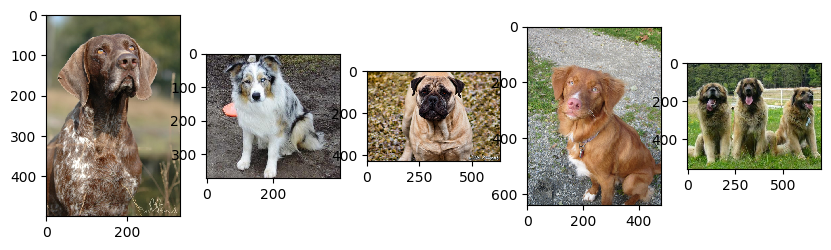

In [4]:
# Set path to image folder
path = "dogImages/train/"

# Visualize random images
image_list = []
for subdir, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            image_list.append(os.path.join(subdir, file))

random_images = random.sample(image_list, 5)
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    image_path = random_images[i]
    img = Image.open(image_path)
    axs[i].imshow(img)
plt.show()

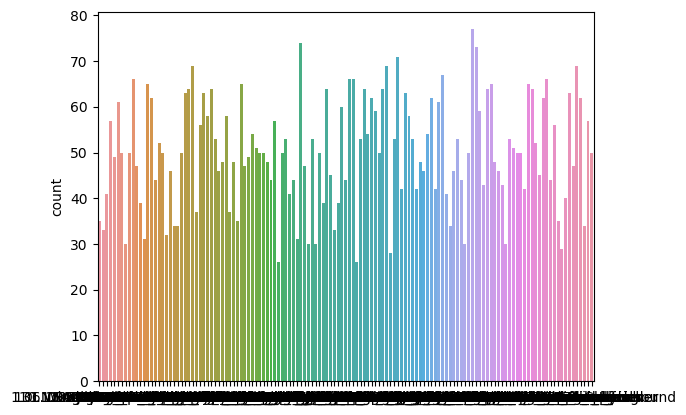

In [5]:
# Class Distribbution
classes = [os.path.basename(os.path.dirname(x)) for x in image_list]
sns.countplot(x=classes)
plt.show()

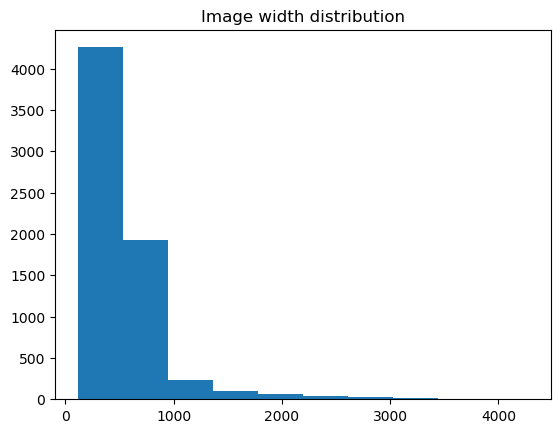

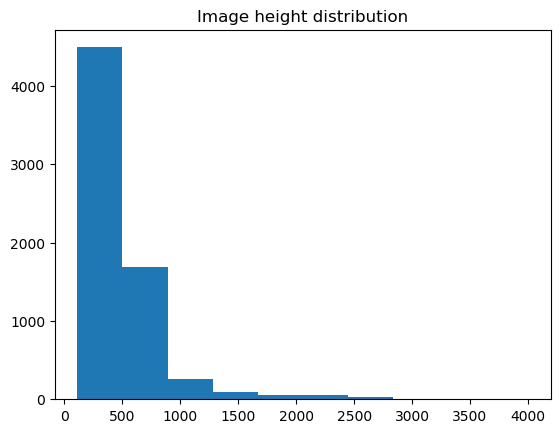

In [6]:
# Image Size Analysis
sizes = []
for img_file in image_list:
    with Image.open(img_file) as img:
        sizes.append(img.size)
sizes = np.array(sizes)
plt.hist(sizes[:, 0])
plt.title("Image width distribution")
plt.show()
plt.hist(sizes[:, 1])
plt.title("Image height distribution")
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'JpegImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  after removing the cwd from sys.path.


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
#TODO: Declare your HP ranges, metrics etc
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [23]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="sagemaker-script-mode",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.8",
    py_version="py36",
)

 # TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [6]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

#input_path = sagemaker_session.upload_data(path="dogImages", bucket=bucket)
os.environ["SM_CHANNEL_TRAINING"] = 's3://sagemaker-us-east-1-125016763263/data'
os.environ['MODEL_DIR']="s3://"+ bucket+ "/model_train/" # store model at this path

In [7]:
input_path = 's3://sagemaker-us-east-1-125016763263/data'

In [8]:
inputs = {"training": input_path }

In [25]:
# TODO: Fit your HP Tuner
tuner.fit(inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................!


In [26]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-01 17:53:28 Starting - Found matching resource for reuse
2023-03-01 17:53:28 Downloading - Downloading input data
2023-03-01 17:53:28 Training - Training image download completed. Training in progress.
2023-03-01 17:53:28 Uploading - Uploading generated training model
2023-03-01 17:53:28 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'lr': '0.0026026829709314353',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"sagemaker-script-mode-2023-03-01-17-39-49-614"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-125016763263/sagemaker-script-mode-2023-03-01-17-39-49-614/source/sourcedir.tar.gz"'}

In [30]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],}
best_hyperparameters

{'batch_size': 64, 'lr': '0.0026026829709314353'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [29]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [37]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", 
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit(input_path ,wait=True)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-01-20-07-13-229


2023-03-01 20:07:13 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-03-01 20:08:01 Starting - Preparing the instances for training......
2023-03-01 20:09:11 Downloading - Downloading input data......
2023-03-01 20:10:12 Training - Downloading the training image......
2023-03-01 20:11:13 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-01 20:11:17,340 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-01 20:11:17,370 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-01 20:11:17,373 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-01 20:11:17,629 sagemaker-training-toolkit INFO     Inv

In [38]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(description)

{'TrainingJobName': 'pytorch-training-2023-03-01-20-07-13-229', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:125016763263:training-job/pytorch-training-2023-03-01-20-07-13-229', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-125016763263/pytorch-training-2023-03-01-20-07-13-229/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'lr': '"0.0026026829709314353"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-03-01-20-07-13-229"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-125016763263/pytorch-training-2023-03-01-20-07-13-229/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.6-gpu-py36', 'TrainingInputMode': 'File', 'EnableSageMakerMetricsTimeSeries': True}, 'RoleArn': 'arn:aws:iam

In [39]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-03-01-20-07-13-229
Region: us-east-1


In [42]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2023-03-01 21:15:26.375 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-01 21:15:26.414 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-125016763263/pytorch-training-2023-03-01-20-07-13-229/debug-output


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


<Figure size 1000x700 with 0 Axes>

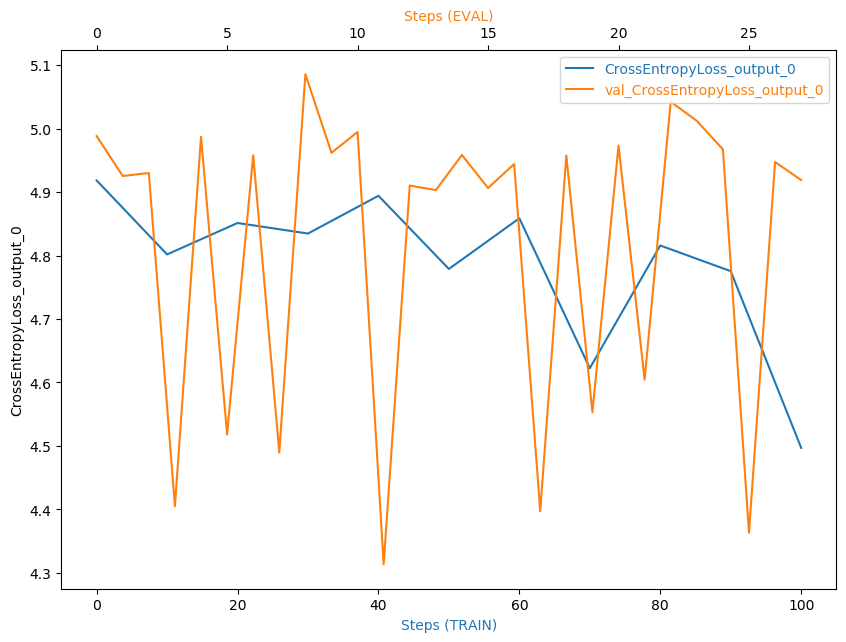

In [48]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


plot_tensor(trial, 'CrossEntropyLoss_output_0') 

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Insights from the Plot

- The training loss decreases with the number of steps.
- The training loss is a bit noisy, may be this means that the training might have required a larger batch size.
- The validation loss is flactuating rigorosuly .

What to be applied if the plot was erronous

Inorder to avoid overfitting we might try the following solutions:

- Maybe I need to use a smaller model compared to the resnet50 like the resnet18 for example.
- Maybe I need to apply regularization to avoid overfitting over the dataset.


In [49]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [50]:
! aws s3 ls {rule_output_path} --recursive

2023-03-01 20:14:15     362509 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-01 20:14:15     209644 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-01 20:14:10        191 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-01 20:14:10       6623 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-01 20:14:10        126 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-01 20:14:10        129 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-01 20:14:10       1411 pytorch-training-2023-03-01-20-07-13-229/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying

In [51]:
# TODO: Deploy your model to an endpoint
model_path = "s3://sagemaker-us-east-1-125016763263/pytorch-training-2023-03-01-20-07-13-229/output/model.tar.gz"
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instance

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-01-22-14-36-513
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-01-22-14-36-513
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-01-22-14-36-513


-----!

In [52]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_path,
                            role = role,
                             entry_point= "inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-01-22-21-37-700
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-01-22-21-38-426
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-01-22-21-38-426


-----------!

Test image no: 1
Below is the image that we will be testing:


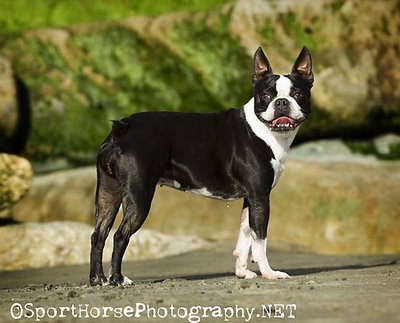

Expected dog breed category no : 32
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.479886054992676, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0087698698043823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Inference for the above image is : [32]
Test image no: 2
Below is the image that we will be testing:


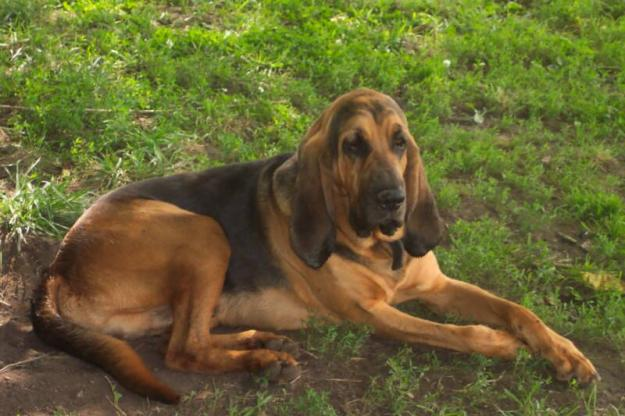

Expected dog breed category no : 27
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Inference for the above image is : [1]
Test image no: 3
Below is the image that we will be testing:


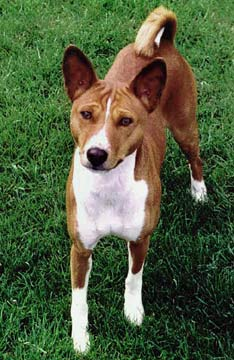

Expected dog breed category no : 14
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03100176900625229, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Inference for the above image is : [50]
Test image no: 4
Below is the image that we will be testing:


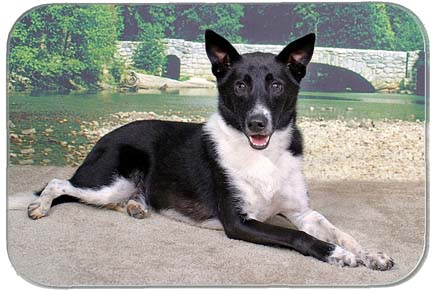

Expected dog breed category no : 43
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1979355812072754, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2029831409454346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Inference for the above image is : [68]


In [55]:
# TODO: Run an prediction on the endpoint

from PIL import Image
import io
import os
import numpy as np

test_dir = "./test_sample"
test_images = ['Boston_terrier.jpg', 'Bloodhound.jpg', 'Basenji.jpg', 'Canaan_dog.jpg']
test_images_expected_output = [32, 27, 14, 43]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Inference for the above image is : {predicted_dog_breed}")


        

In [56]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-01-22-21-38-426
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-01-22-21-38-426
